In [168]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import RandomOverSampler
from collections import OrderedDict
import pickle
import warnings
warnings.simplefilter("ignore")

In [169]:
df = pd.read_csv('water_potability.csv')

In [170]:
df.shape

(3276, 10)

In [171]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


## Descriptive statistics of numeric features

In [172]:
def descriptive_statistics(data) :
    
    result = []
    
    for col in data.columns :
        
        if data[col].dtype != 'O':   
            
 # initialise the dictionary
            stats = OrderedDict({
                "Feature_Name" : col ,
                "Count" : data[col].count() , 
                "Minimum" : data[col].min(),
                "First quartile" :data[col].quantile(0.25),
                "Mean" : data[col].mean(),
                "Median" : data[col].median(),
                "Third quartile":data[col].quantile(0.75),
                "Maximum" : data[col].max(),
                "Variance" : data[col].var(),
                "standard deviation": data[col].std(),
                "Kurtosis" : data[col].kurt(),
                "Skewness" : data[col].skew(),
                "IQR" : data[col].quantile(0.75) - data[col].quantile(0.25)
            })
            
            result.append(stats)
            
    
    result_df = pd.DataFrame(result, )
    
    skewtype = []
    
    
    for i in result_df['Skewness'] :
        
        if i <= -1:
            skewtype.append("Highly Negatively Skewed")
            
        elif i<= -0.5:
            skewtype.append("Moderately Negatively Skewed")
            
        elif -0.5 < i < 0 :
            skewtype.append("Approx Normal Distribution(-ve)")
            
        elif 0 <= i < 0.5:
            skewtype.append("Approx Normal Distribution(+ve)")
            
        elif 0.5 <= i <1 :
             skewtype.append("Moderately positively skewed")
        
        elif i >= 1:
             skewtype.append("Highly positively skewed")
    
    
    result_df["Skew_Type"] = skewtype



    k_type = []
    
    
    for i in result_df['Kurtosis'] :
        
        if i <= -1  :
            k_type.append("Highly platykurtic curve")
            
        elif -1 < i <= 0.5 :
            k_type.append("Moderately platykurtic curve")
            
        elif -0.5 < i <= 0.5 :
            k_type.append("Mesokurtic curve")
            
        elif 0.5 < i <= 1 :
            k_type.append("Moderately leptokurtic curve")
            
        elif i > 1 :
            k_type.append("Highly leptokurtic curve")

    
    result_df["kurtosis_Type"] = k_type
    
    
   
    
    up_limit = stats["Third quartile"] + 1.5 * stats["IQR"]
    
    low_limit = stats["First quartile"] - 1.5 * stats["IQR"]
    
    if len([x for x in data[col] if x < low_limit or x > up_limit]) > 0 :
        outlier_comment = "Has outliers"
        outlier_percentage = len([x for x in data[col] if x < low_limit or x > up_limit]) / len(data)
    else:
        outlier_comment = "No outliers"
        outlier_percentage = 0
        
    result_df['Outlier_Comment'] = outlier_comment
    
    result_df['Outlier_Percentage'] = outlier_percentage

    
    return result_df
    


In [173]:
descrp_stats = descriptive_statistics(df)

In [174]:
descrp_stats

,Feature_Name,Count,Minimum,First quartile,Mean,Median,Third quartile,Maximum,Variance,standard deviation,Kurtosis,Skewness,IQR,Skew_Type,kurtosis_Type,Outlier_Comment,Outlier_Percentage
0,ph,2785,0.000000,6.093092,7.080795,7.036752,8.062066,14.000000,2.541855e+00,1.594320,0.720316,0.025630,1.968974,Approx Normal Distribution(+ve),Moderately leptokurtic curve,No outliers,0
1,Hardness,3276,47.432000,176.850538,196.369496,196.967627,216.667456,323.124000,1.081079e+03,32.879761,0.615772,-0.039342,39.816918,Approx Normal Distribution(-ve),Moderately leptokurtic curve,No outliers,0
2,Solids,3276,320.942611,15666.690300,22014.092526,20927.833605,27332.762125,61227.196010,7.688783e+07,8768.570828,0.442826,0.621634,11666.071825,Moderately positively skewed,Moderately platykurtic curve,No outliers,0
3,Chloramines,3276,0.352000,6.127421,7.122277,7.130299,8.114887,13.127000,2.506158e+00,1.583085,0.589901,-0.012098,1.987466,Approx Normal Distribution(-ve),Moderately leptokurtic curve,No outliers,0
4,Sulfate,2495,129.000000,307.699498,333.775777,333.073546,359.950170,481.030642,1.715355e+03,41.416840,0.648263,-0.035947,52.250673,Approx Normal Distribution(-ve),Moderately leptokurtic curve,No outliers,0
5,Conductivity,3276,181.483754,365.734414,426.205111,421.884968,481.792305,753.342620,6.532529e+03,80.824064,-0.277093,0.264490,116.057890,Approx Normal Distribution(+ve),Moderately platykurtic curve,No outliers,0
6,Organic_carbon,3276,2.200000,12.065801,14.284970,14.218338,16.557652,28.300000,1.094394e+01,3.308162,0.044409,0.025533,4.491850,Approx Normal Distribution(+ve),Moderately platykurtic curve,No outliers,0
7,Trihalomethanes,3114,0.738000,55.844536,66.396293,66.622485,77.337473,124.000000,2.616309e+02,16.175008,0.238597,-0.083031,21.492937,Approx Normal Distribution(-ve),Moderately platykurtic curve,No outliers,0
8,Turbidity,3276,1.450000,3.439711,3.966786,3.955028,4.500320,6.739000,6.089967e-01,0.780382,-0.062801,-0.007817,1.060609,Approx Normal Distribution(-ve),Moderately platykurtic curve,No outliers,0
9,Potability,3276,0.000000,0.000000,0.390110,0.000000,1.000000,1.000000,2.379968e-01,0.487849,-1.797892,0.450784,1.000000,Approx Normal Distribution(+ve),Highly platykurtic curve,No outliers,0


In [175]:
descrp_stats[['Feature_Name', 'Outlier_Percentage', 'Skew_Type', 'kurtosis_Type']]

,Feature_Name,Outlier_Percentage,Skew_Type,kurtosis_Type
0,ph,0,Approx Normal Distribution(+ve),Moderately leptokurtic curve
1,Hardness,0,Approx Normal Distribution(-ve),Moderately leptokurtic curve
2,Solids,0,Moderately positively skewed,Moderately platykurtic curve
3,Chloramines,0,Approx Normal Distribution(-ve),Moderately leptokurtic curve
4,Sulfate,0,Approx Normal Distribution(-ve),Moderately leptokurtic curve
5,Conductivity,0,Approx Normal Distribution(+ve),Moderately platykurtic curve
6,Organic_carbon,0,Approx Normal Distribution(+ve),Moderately platykurtic curve
7,Trihalomethanes,0,Approx Normal Distribution(-ve),Moderately platykurtic curve
8,Turbidity,0,Approx Normal Distribution(-ve),Moderately platykurtic curve
9,Potability,0,Approx Normal Distribution(+ve),Highly platykurtic curve


In [176]:
# No outliers present in any of the features

## Feature Engineering

In [177]:
# Percentage of missing values in each feature

((df.isnull().sum()/len(df))*100).sort_values(ascending=False)

Sulfate            23.840049
ph                 14.987790
Trihalomethanes     4.945055
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Conductivity        0.000000
Organic_carbon      0.000000
Turbidity           0.000000
Potability          0.000000
dtype: float64

In [178]:
# Treating missing values
#1) Trihalomethanes
#2) pH
#3) Sulfate

In [179]:
# To make sure thee is no disturbance in the data distribution before and after treating missing values

df_old = df

<AxesSubplot:xlabel='Sulfate', ylabel='Density'>

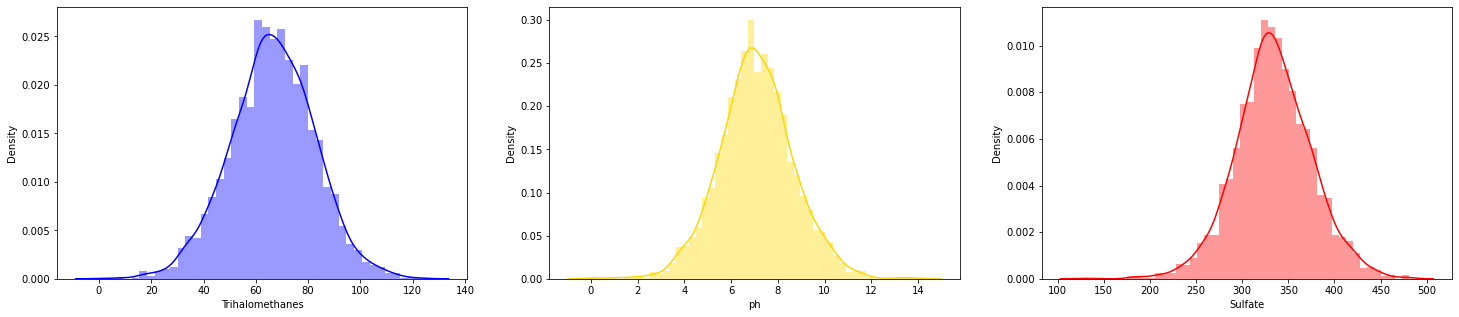

In [180]:
# Distribution before imputing missing values

plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
sns.distplot(df_old['Trihalomethanes'], color = 'Blue', label='Trihalomethanes')
plt.subplot(1,3,2)
sns.distplot(df_old['ph'], color = 'gold', label='pH')
plt.subplot(1,3,3)
sns.distplot(df_old['Sulfate'], color = 'red', label='Sulfate')

In [181]:
# Treating the missing values by  KNN Imputation technique

imputer = KNNImputer(n_neighbors=3,  weights='uniform')
imputer.fit(df_old)
cols=[cols for cols in df.columns]
df_new=imputer.transform(df_old)

In [182]:
df_new = pd.DataFrame(df_new, columns=cols)
df_new

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,6.655223,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0.0
1,3.716080,129.422921,18630.05786,6.635246,351.285226,592.885359,15.180013,56.329076,4.500656,0.0
2,8.099124,224.236259,19909.54173,9.275884,347.323743,418.606213,16.868637,66.420093,3.055934,0.0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0.0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0.0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681736,47580.99160,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1.0
3272,7.808856,193.553212,17329.80216,8.061362,368.086095,392.449580,19.903225,56.689055,2.798243,1.0
3273,9.419510,175.762646,33155.57822,7.350233,316.571962,432.044783,11.039070,69.845400,3.298875,1.0
3274,5.126763,230.603758,11983.86938,6.303357,334.293597,402.883113,11.168946,77.488213,4.708658,1.0


In [183]:
# Percentage of missing values after imputation

(df.isnull().sum()/len(df))*100

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

<AxesSubplot:xlabel='Sulfate', ylabel='Density'>

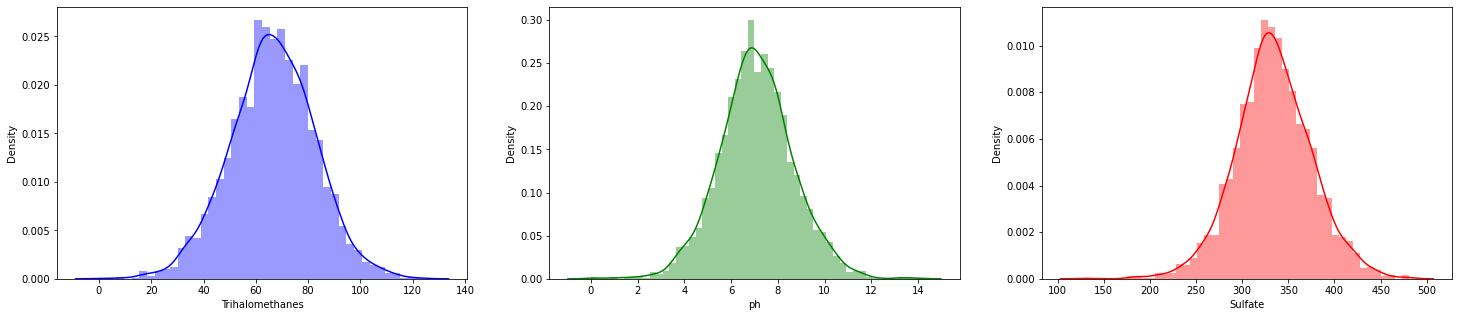

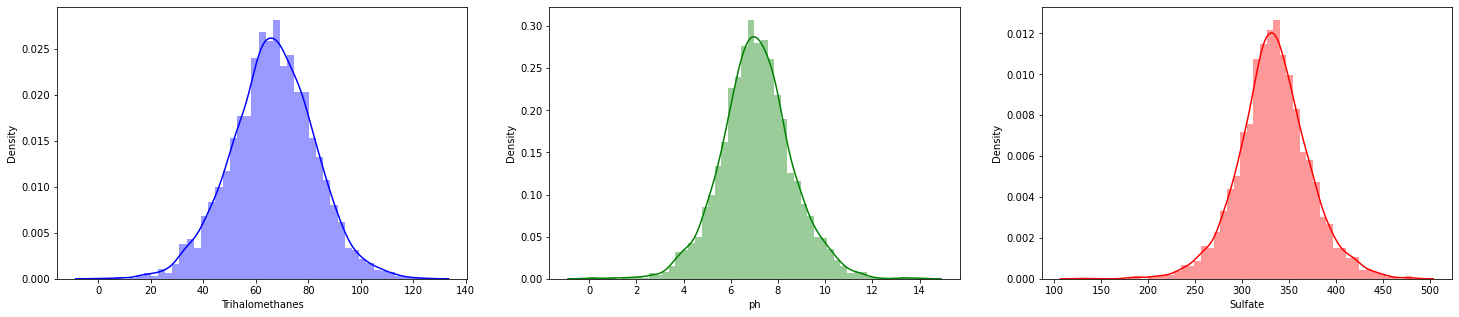

In [184]:
# Comparing data distribution before and after imputation:

# Distribution before imputing missing values

plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
sns.distplot(df_old['Trihalomethanes'], color = 'Blue', label='Trihalomethanes')
plt.subplot(1,3,2)
sns.distplot(df_old['ph'], color = 'green', label='pH')
plt.subplot(1,3,3)
sns.distplot(df_old['Sulfate'], color = 'red', label='Sulfate')

# Distribution after imputing missing values

plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
sns.distplot(df_new['Trihalomethanes'], color = 'Blue', label='Trihalomethanes')
plt.subplot(1,3,2)
sns.distplot(df_new['ph'], color = 'green', label='pH')
plt.subplot(1,3,3)
sns.distplot(df_new['Sulfate'], color = 'red', label='Sulfate')

When we compare the distribution of each feature before and after imputation, the distribution remains relatively the same.

In [185]:
df = df_new

### Imbalanced Dataset

In [186]:
# Splitting the data into X and y

X = df.drop('Potability', axis=1)
y = df['Potability']

<AxesSubplot:xlabel='Potability', ylabel='count'>

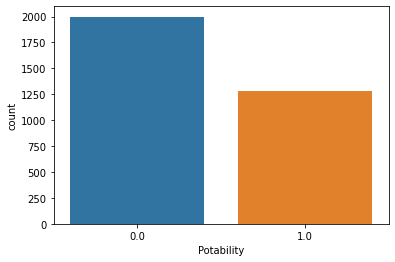

In [187]:
sns.countplot(y)

In [188]:
# As we can see the target variable is imbalanced. Let us fix that by performing Oversampling.

In [189]:
ros = RandomOverSampler()
X, y = ros.fit_resample(X, y)

<AxesSubplot:xlabel='Potability', ylabel='count'>

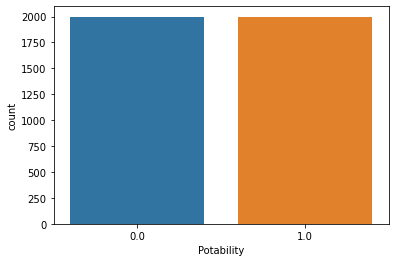

In [190]:
sns.countplot(y)

In [191]:
# The target feature is now balanced

### Feature Selection

In [192]:
# Feature importance using Chi Square 

bestfeatures = SelectKBest(score_func=chi2, k=8)
fit = bestfeatures.fit(X,y)

In [193]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [194]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

In [195]:
featureScores

,Specs,Score
0,ph,0.063968
1,Hardness,3.149209
2,Solids,36526.868995
3,Chloramines,1.051895
4,Sulfate,13.263013
5,Conductivity,3.921813
6,Organic_carbon,2.803492
7,Trihalomethanes,2.617584
8,Turbidity,0.059389


In [196]:
print(featureScores.nlargest(9,'Score'))  #print 10 best features

             Specs         Score
2           Solids  36526.868995
4          Sulfate     13.263013
5     Conductivity      3.921813
1         Hardness      3.149209
6   Organic_carbon      2.803492
7  Trihalomethanes      2.617584
3      Chloramines      1.051895
0               ph      0.063968
8        Turbidity      0.059389


In [197]:
# Training the model with the top 6 most important features

X.drop(['Turbidity', 'Conductivity', 'Chloramines'], axis=1, inplace=True)

In [198]:
# Train-Test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [199]:
X_train

,ph,Hardness,Solids,Sulfate,Organic_carbon,Trihalomethanes
1869,6.548018,176.006536,38368.01262,278.093309,19.422535,81.368568
1872,6.136907,151.784319,20561.69473,384.156079,13.713703,96.582865
1230,7.943882,211.816551,32071.17937,290.337398,17.871950,78.492783
2439,7.895769,168.724047,28723.61763,353.976181,11.992772,79.860552
2229,7.807834,163.957240,19516.89804,393.840917,14.842674,69.006856
...,...,...,...,...,...,...
1911,6.851443,197.339559,15349.14258,340.516028,11.367275,79.155822
1066,8.567044,160.217867,23683.11019,360.286282,9.027167,67.476229
1094,7.741245,218.237187,22824.69947,363.992748,15.310631,73.723070
3270,6.069616,186.659040,26138.78019,345.700257,12.067620,60.419921


In [200]:
# Model accuracy function

def classification_model(X_train, X_test, y_train, y_test):
    classifiers = []
    accuracy = []
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neighbors import KNeighborsClassifier
    lr = LogisticRegression()
    dt = DecisionTreeClassifier(max_depth=4)
    knn = KNeighborsClassifier(n_neighbors=9)
    xgb = XGBClassifier(learning_rate=0.7)
    rf=RandomForestClassifier()
    lr.fit(X_train,y_train)
    for mod in [lr, dt, knn, rf, xgb]:
        mod.fit(X_train,y_train)
    for mod in [lr, dt, knn, rf, xgb]:
        y_pred=mod.predict(X_test)
        if mod == rf:
            classifiers.append('Random Forest')
        else:
            classifiers.append(mod)
        accuracy.append(accuracy_score(y_test, y_pred))
    accuracy_scores = pd.DataFrame({'Model Name':classifiers, 'Accuracy Score':accuracy})
    return accuracy_scores

In [201]:
acc = classification_model(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test).sort_values(by='Accuracy Score', ascending=False)
acc

[01:56:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model Name,Accuracy Score
3,Random Forest,0.756464
4,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.700584
1,DecisionTreeClassifier(max_depth=4),0.582152
2,KNeighborsClassifier(n_neighbors=9),0.556297
0,LogisticRegression(),0.510425


In [202]:
# Random Forest Cross validation score

scores = cross_val_score(rf, X, y, cv=10)
print('The mean accuracy is ', np.mean(scores))

The mean accuracy is  0.7630946115288221


In [203]:
# Creating pickle file

filename = 'random_forest.pkl'
pickle.dump(rf, open(filename, 'wb'))

In [204]:
# Random Forest Hyperparameter tuning
#params = {"n_estimators": range(10,310,10), "criterion": ['gini', 'entropy'], "max_depth": range(3,50)}

#grid_cv = GridSearchCV(rf, params, cv = 10)

#grid_cv.fit(X_train, y_train)
  
#grid_cv.best_params_